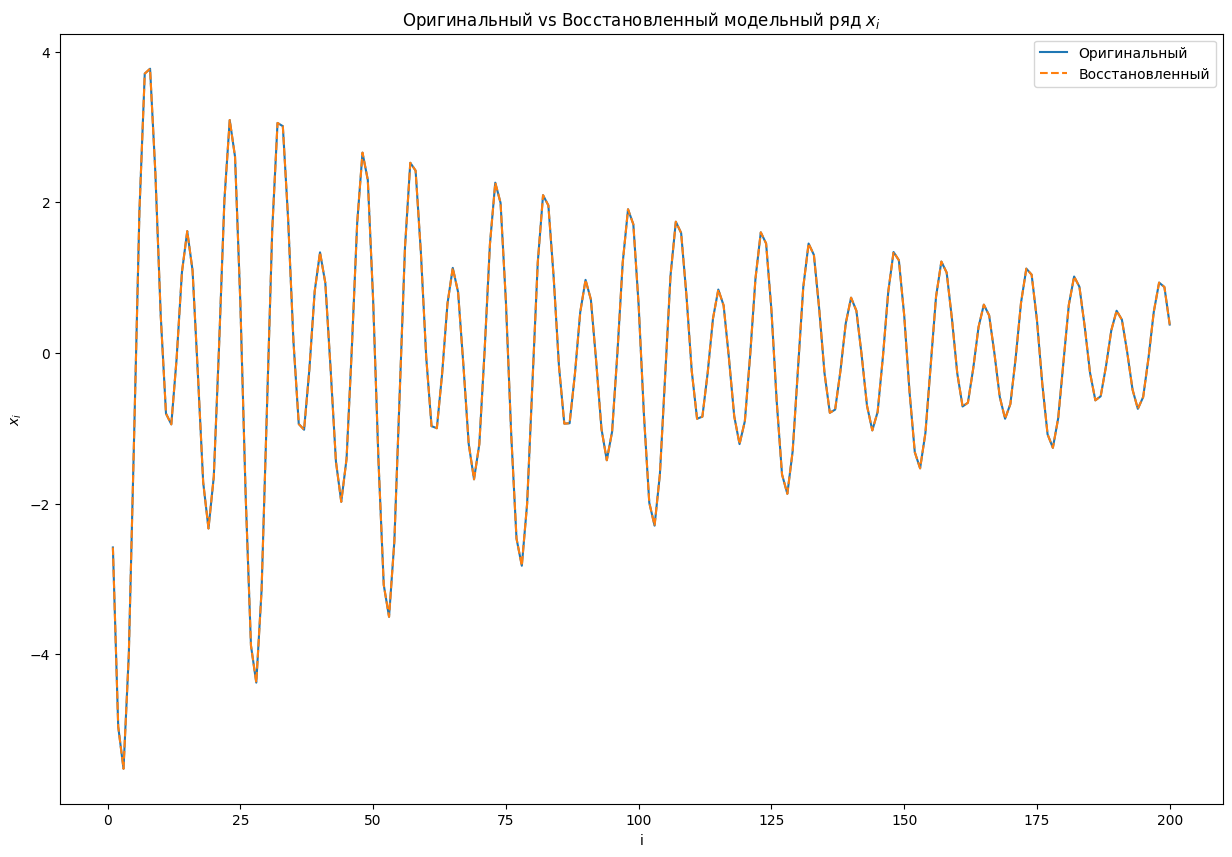

MSE: 1.532982631108766e-23


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# 1. Реализация метода Прони

def prony(x, m, delta_t=1.0):
    n = len(x)
    rows = n - m
    X = np.zeros((rows, m), dtype=complex)
    y = np.zeros(rows, dtype=complex)
    x = np.array(x, dtype=complex)
    for r in range(rows):
        for j in range(m):
            X[r, j] = x[m + r - j - 1]
        y[r] = x[m + r]
    a = np.linalg.lstsq(X, -y, rcond=None)[0]
    coeffs = np.concatenate(([1.], a))
    z = np.roots(coeffs)
    lambda_r = np.log(np.abs(z)) / delta_t
    omega_r = np.arctan2(np.imag(z), np.real(z)) / (2 * np.pi * delta_t)
    V = np.zeros((n, m), dtype=complex)
    for k in range(n):
        for r in range(m):
            V[k, r] = z[r] ** k
    h = np.linalg.lstsq(V, x, rcond=None)[0]
    A = np.abs(h)
    phi = np.arctan2(np.imag(h), np.real(h))
    return lambda_r, omega_r, A, phi

# Модельный ряд x_i
h = 0.02
n = 200
i = np.arange(1, n + 1)
x = np.zeros(n)
for k in range(1, 4):
    x += k * np.exp(-h * i / k) * np.cos(4 * np.pi * h * i * k + np.pi / k)

# Применение метода Прони к модельному ряду
lambda_r, omega_r, A, phi = prony(x, 6)

# Оригинальный модельный ряд vs восстановленный
V = np.zeros((n, 6), dtype=complex)
z = np.exp((lambda_r + 2j * np.pi * omega_r))
for k in range(n):
    for r in range(6):
        V[k, r] = z[r] ** k
h_complex = np.linalg.lstsq(V, x, rcond=None)[0]
x_approx = np.real(V @ h_complex)

plt.figure(figsize=(15, 10))
plt.plot(i, x, label='Оригинальный')
plt.plot(i, x_approx, label='Восстановленный', linestyle='--')
plt.legend()
plt.title('Оригинальный vs Восстановленный модельный ряд $x_i$')
plt.xlabel('i')
plt.ylabel('$x_i$')
plt.show()

# Проверка качества восстановления
mse = np.mean((x - x_approx)**2)
print(f"MSE: {mse}")


In [2]:
print("=" * 80)
print("РЕЗУЛЬТАТЫ МЕТОДА ПРОНИ")
print("=" * 80)
print(f"{'Компонента':<12} {'Затухание (λ)':<18} {'Частота (ω)':<15} {'Амплитуда (A)':<15} {'Фаза (φ)':<15}")
print("-" * 80)

for i in range(len(lambda_r)):
    print(f"{i+1:<12} {lambda_r[i]:<18.6f} {omega_r[i]:<15.6f} {A[i]:<15.6f} {phi[i]:<15.6f}")

print("-" * 80)

РЕЗУЛЬТАТЫ МЕТОДА ПРОНИ
Компонента   Затухание (λ)      Частота (ω)     Амплитуда (A)   Фаза (φ)       
--------------------------------------------------------------------------------
1            -0.006667          0.120000        1.490033        1.801180       
2            -0.010000          0.080000        0.990050        2.073451       
3            -0.020000          0.040000        0.490099        -2.890265      
4            -0.006667          -0.120000       1.490033        -1.801180      
5            -0.020000          -0.040000       0.490099        2.890265       
6            -0.010000          -0.080000       0.990050        -2.073451      
--------------------------------------------------------------------------------


In [3]:
# 2. Анализ температур в Санкт-Петербурге за 2023-2025

df = pd.read_csv('data/temperatures.csv')
df['date'] = pd.to_datetime(df['datetime'])
df.set_index('date', inplace=True)
df = df.asfreq('D') 

decomposition = seasonal_decompose(df['temp'], model='additive', period=365)

# Проверка тренда
from scipy.stats import linregress
trend = decomposition.trend.dropna()
slope, intercept, r_value, p_value, std_err = linregress(range(len(trend)), trend)
if p_value < 0.05:
    print("Статистически значимый тренд (p-value < 0.05)")
else:
    print("Нет статистически значимого тренда")

print("Частота: ", slope)

# Анализ сезонности по месяцам
seasonal_amplitude = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

print("\n" + "="*30)
print("СЕЗОННАЯ КОМПОНЕНТА ТЕМПЕРАТУР")
print("="*30)

months = [
    "Январь", "Февраль", "Март", "Апрель", "Май", "Июнь",
    "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"
]

print(f"{'Месяц':<15} {'Температура':<12}")
print("-"*30)

for month_num in range(1, 13):
    temp = seasonal_amplitude[month_num]
    deviation = f"{temp:+.2f}°C"
    
    print(f"{months[month_num-1]:<15} {deviation:<12}")

print("-"*30)


Статистически значимый тренд (p-value < 0.05)
Частота:  0.002729163695531515

СЕЗОННАЯ КОМПОНЕНТА ТЕМПЕРАТУР
Месяц           Температура 
------------------------------
Январь          -16.20°C    
Февраль         -10.79°C    
Март            -4.32°C     
Апрель          -0.95°C     
Май             +6.07°C     
Июнь            +10.98°C    
Июль            +11.38°C    
Август          +13.26°C    
Сентябрь        +9.48°C     
Октябрь         -1.69°C     
Ноябрь          -6.58°C     
Декабрь         -11.66°C    
------------------------------


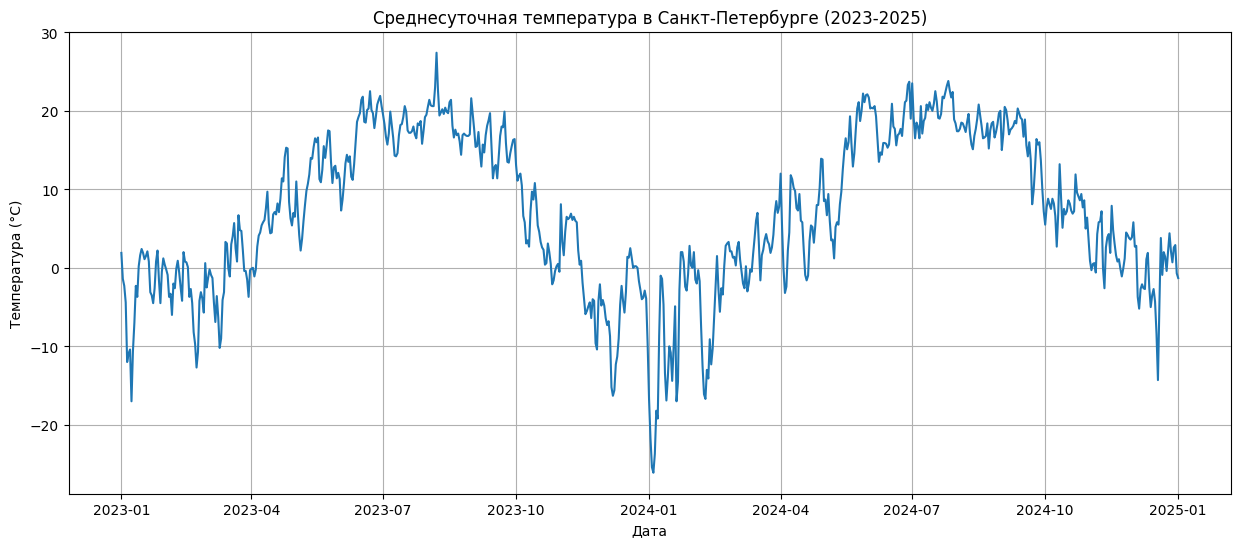

In [4]:
# Визуализация исходных данных
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['temp'])
plt.title('Среднесуточная температура в Санкт-Петербурге (2023-2025)')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.grid(True)
plt.show()

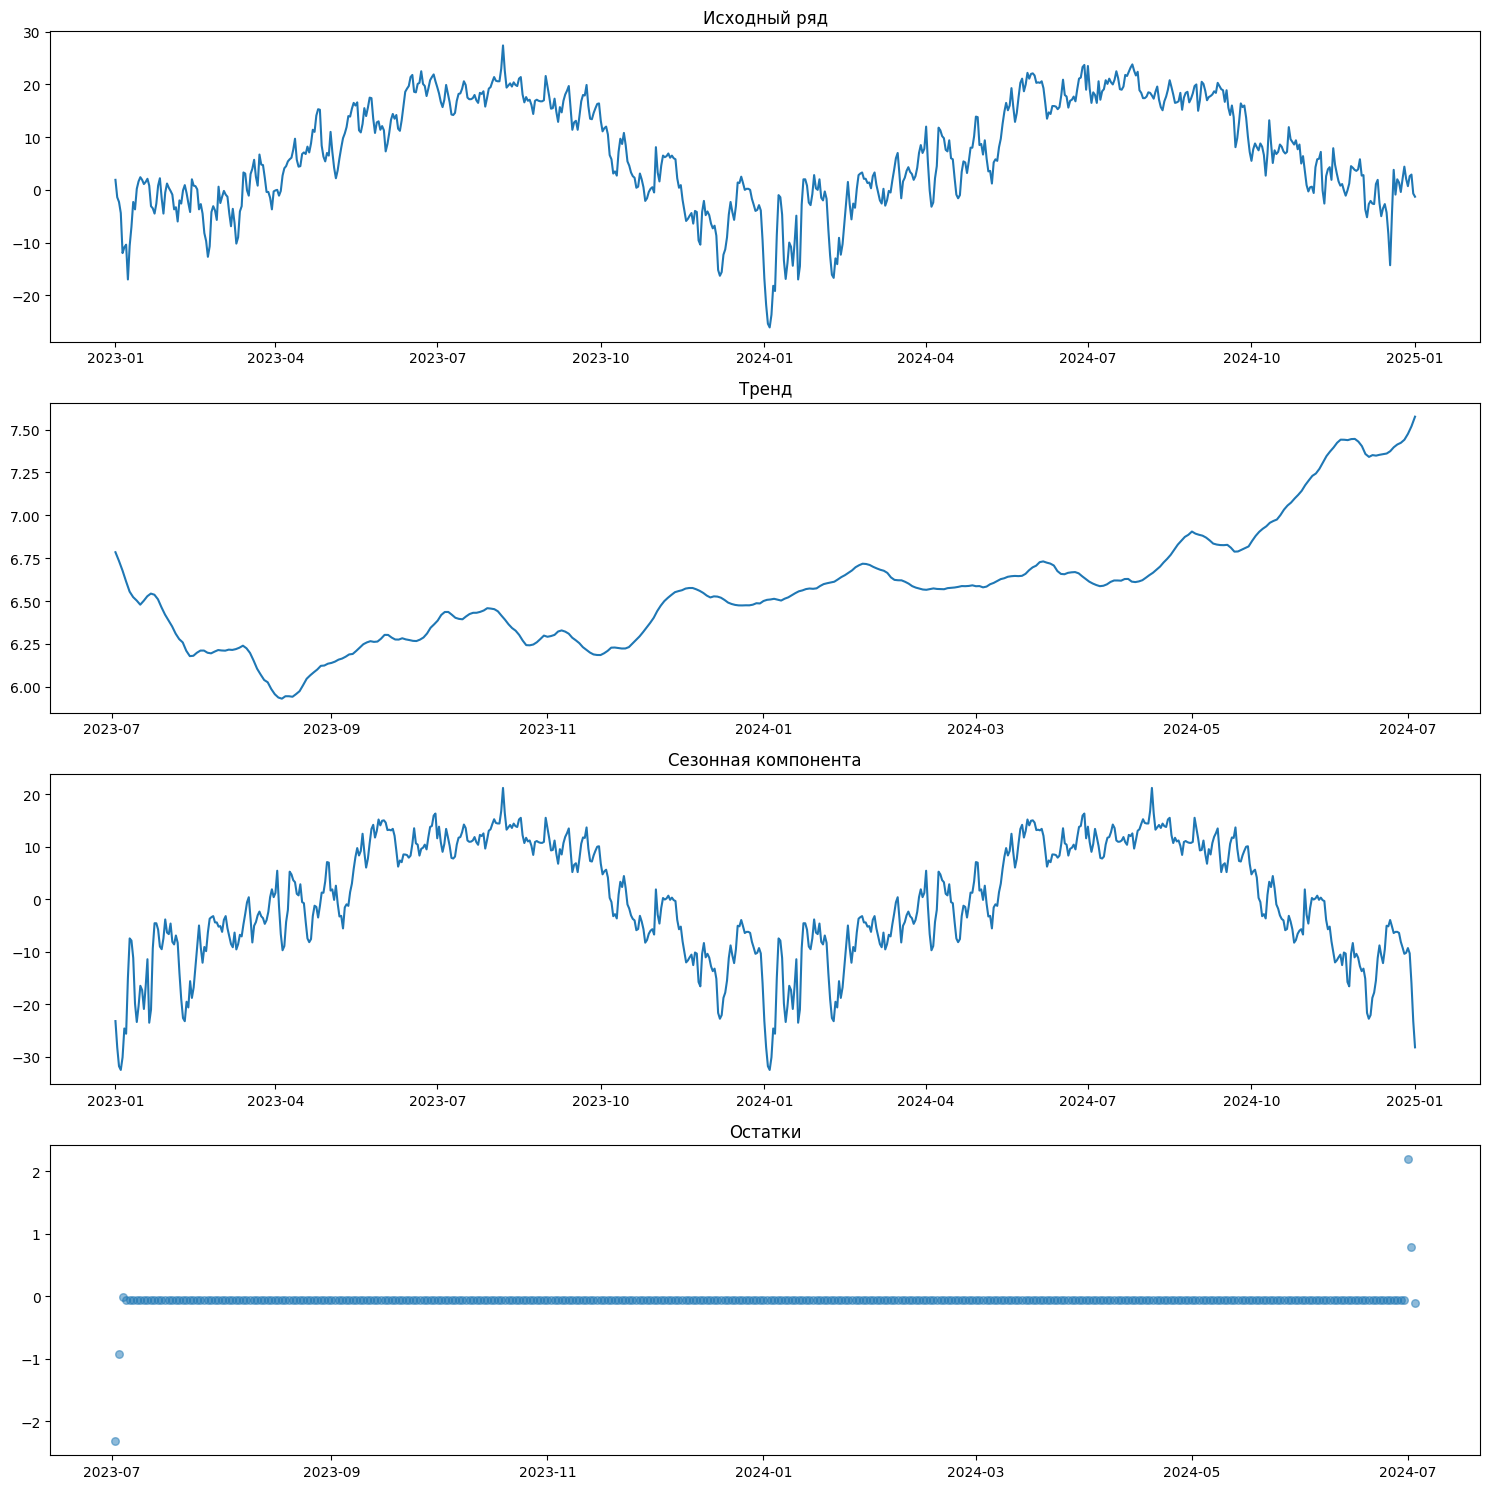

In [5]:
# Анализ тренда, сезонности и остатков
decomposition = seasonal_decompose(df['temp'], model='additive', period=365)

plt.figure(figsize=(15, 15))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Исходный ряд')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Тренд')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Сезонная компонента')

plt.subplot(4, 1, 4)
plt.scatter(decomposition.resid.index, decomposition.resid, s=30, alpha=0.5)
plt.title('Остатки')
plt.tight_layout()
plt.show()

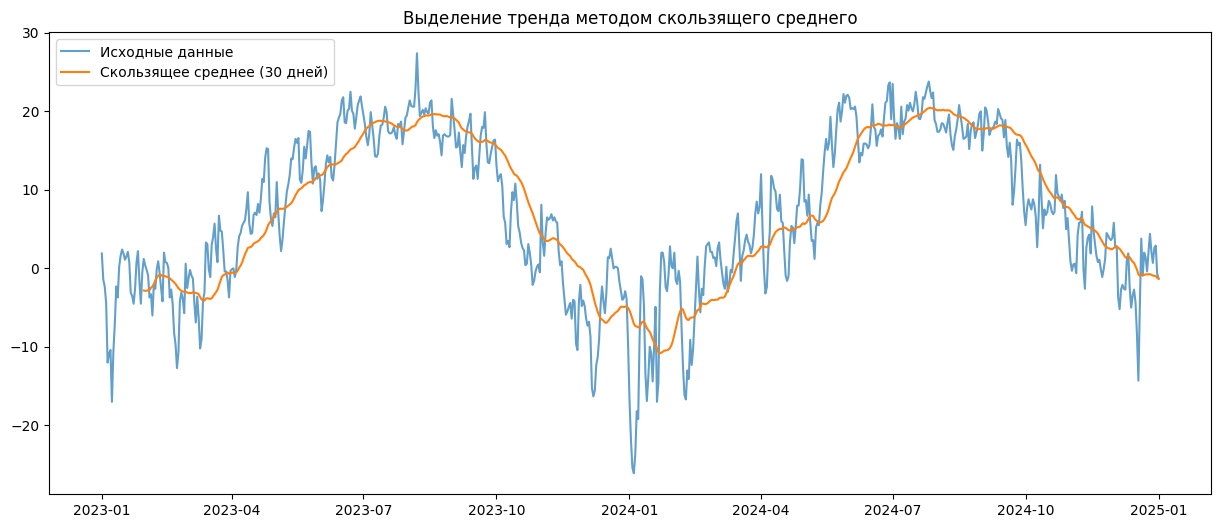

In [6]:
# Дополнительный анализ: скользящее среднее для тренда
window = 30
df['moving_avg'] = df['temp'].rolling(window=window).mean()

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['temp'], alpha=0.7, label='Исходные данные')
plt.plot(df.index, df['moving_avg'], label=f'Скользящее среднее ({window} дней)')
plt.title('Выделение тренда методом скользящего среднего')
plt.legend()
plt.show()